In [1]:
from merfish3danalysis.qi2labDataStore import qi2labDataStore
from merfish3danalysis.DataRegistration import DataRegistration
from pathlib import Path
import numpy as np
import gc
from tqdm import tqdm
from tifffile import TiffWriter
from typing import Optional

from multiview_stitcher import spatial_image_utils as si_utils
from multiview_stitcher import msi_utils, registration, fusion
import dask.diagnostics
import dask.array as da


/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/pycudadecon/_libwrap.py:44: UserWarning: Unable to find function: camcor_interface_init in libcudaDecon
  @lib.function
/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/pycudadecon/_libwrap.py:51: UserWarning: Unable to find function: camcor_interface in libcudaDecon
  @lib.function


In [2]:
import napari 

viewer = napari.Viewer(ndisplay=3, show=True)

: 

In [35]:
root_path = Path(r"/mnt/d/EQUIPEX/Data/20250404_Abberior_Merfish_7C")

# initialize datastore
datastore_path = root_path / Path(r"qi2labdatastore")
datastore = qi2labDataStore(datastore_path)

In [36]:
# load tile positions
for tile_idx, tile_id in enumerate(datastore.tile_ids):
    round_id = datastore.round_ids[0]
    tile_position_zyx_um = datastore.load_local_stage_position_zyx_um(
        tile_id, round_id
    )

In [37]:
# convert local tiles from first round to multiscale spatial images
msims = []
for tile_idx, tile_id in enumerate(tqdm(datastore.tile_ids, desc="tile")):
    round_id = datastore.round_ids[0]

    voxel_zyx_um = datastore.voxel_size_zyx_um

    scale = {"z": voxel_zyx_um[0], "y": voxel_zyx_um[1], "x": voxel_zyx_um[1]}

    tile_stage_position_zyx_um, tile_affine_zyx_px = datastore.load_local_stage_position_zyx_um(
        tile_id, round_id
    )

    tile_grid_positions = {
        "z": np.round(tile_stage_position_zyx_um[0], 2),
        "y": np.round(tile_stage_position_zyx_um[1], 2),
        "x": np.round(tile_stage_position_zyx_um[2], 2),
    }

    im_data = []
    im_data = datastore.load_local_registered_image(
        tile=tile_id, round=round_id, return_future=False
    )

    sim = si_utils.get_sim_from_array(
        da.expand_dims(im_data, axis=0),
        dims=("c", "z", "y", "x"),
        scale=scale,
        translation=tile_grid_positions,
        transform_key="stage_metadata",
    )

    msim = msi_utils.get_msim_from_sim(sim, scale_factors=[])
    msims.append(msim)
    del im_data
    gc.collect()

tile: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


In [38]:
sim

<xarray.DataArray 'image' (t: 1, c: 1, z: 276, y: 1649, x: 1606)> Size: 1GB
dask.array<xarray-<this-array>, shape=(1, 1, 276, 1649, 1606), dtype=uint16, chunksize=(1, 1, 256, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * t        (t) int64 8B 0
  * c        (c) int64 8B 0
  * z        (z) float64 2kB -26.56 -26.53 -26.5 -26.47 ... -18.37 -18.34 -18.31
  * y        (y) float64 13kB 4.79e+03 4.79e+03 4.79e+03 ... 4.897e+03 4.897e+03
  * x        (x) float64 13kB 6.94e+03 6.94e+03 6.94e+03 ... 7.044e+03 7.044e+03
Attributes:
    transforms:  {'stage_metadata': <xarray.DataArray (x_in: 4, x_out: 4)> Si...

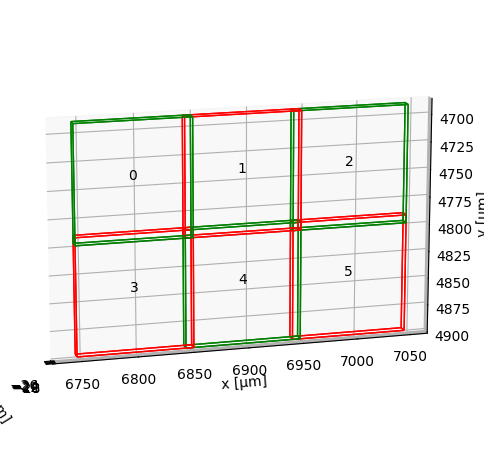

In [40]:
from multiview_stitcher import vis_utils
fig, ax = vis_utils.plot_positions(
    msims,
    use_positional_colors=True, # set to False for faster execution in case of more than 20 tiles/views
    transform_key='stage_metadata'
    )

In [42]:
import napari 
from napari_stitcher import viewer_utils

ch_coord = 0 # None if all should be shown

viewer = napari.Viewer(ndisplay=msi_utils.get_ndim(msims[0]))
lds = viewer_utils.create_image_layer_tuples_from_msims(
    msims, ch_coord=ch_coord, transform_key='affine_metadata', n_colors=2, contrast_limits=[0, 500])
viewer_utils.add_image_layer_tuples_to_viewer(viewer, lds)
viewer.reset_view()


Available platform plugins are: eglfs, minimal, minimalegl, offscreen, vnc, webgl, xcb.



: 

In [41]:
# perform registration in 2 steps, from most downsampling to least.
with dask.config.set(**{"array.slicing.split_large_chunks": False}):
    with dask.diagnostics.ProgressBar():
        _ = registration.register(
            msims,
            reg_channel_index=0,
            transform_key="stage_metadata",
            new_transform_key="translation_registered_3x",
            registration_binning={"z": 3, "y": 9, "x": 9},
            post_registration_do_quality_filter=True,
        )

        _ = registration.register(
            msims,
            reg_channel_index=0,
            transform_key="translation_registered_3x",
            new_transform_key="translation_registered",
            registration_binning={"z": 1, "y": 3, "x": 3},
            post_registration_do_quality_filter=True,
        )

[########################################] | 100% Completed | 908.85 ms
[########################################] | 100% Completed | 407.62 ms
[                                        ] | 0% Completed | 116.77 us

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 204.84 ms
[#################                       ] | 43% Completed | 104.51 ms

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 407.06 ms
[                                        ] | 0% Completed | 123.72 us

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 204.40 ms
[#######################                 ] | 57% Completed | 104.27 ms

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 205.03 ms
[#################                       ] | 42% Completed | 105.78 ms

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 409.15 ms
[                                        ] | 0% Completed | 166.29 us

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 308.05 ms
[                                        ] | 0% Completed | 150.55 us

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 907.87 ms
[########################################] | 100% Completed | 508.19 ms
[################################        ] | 81% Completed | 102.59 ms

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 505.51 ms
[###################                     ] | 49% Completed | 103.67 ms

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 607.71 ms
[                                        ] | 0% Completed | 130.97 us

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 505.68 ms


/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 505.72 ms
[###################                     ] | 48% Completed | 103.70 ms

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 507.51 ms
[###################                     ] | 48% Completed | 100.96 ms

/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)


[########################################] | 100% Completed | 504.43 ms


/home/hugob/miniforge3/envs/merfish3d/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: An overlap region between tiles/views is all zero or constant. Assuming identity transform.
  return func(*args, **kwargs)
